# Decode against a preodor baseline period, within a trial type. Must have at least 5 trials of a specific trial type/outcome for animal to contribute to decoding for that particular trial type

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_dhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'Not_Run', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'Not_Run_HP', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'sig_vs_chance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
(

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        #print ani,np.shape(np.where(labels[ani]==classes[0]))[-1]
        if np.shape(np.where(labels[ani]==classes[0]))[-1]>=5:  #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(labels[ani]==l)[0])
                    if train_test_split<1:
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
            #print '(NO',ani,')',
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def Not_Run(patterns, labels, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns(patterns, labels, **args)
    return not_run,sum(which_cells)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

def combine_patterns(patterns, labels, n_patterns=100, classes=[0, 1], labels_mask=None):
    labels_comb = np.r_[list(classes)*n_patterns]
    patterns_comb_train = []
    for i in xrange(n_patterns):
        for odor in classes:
            try:
                p = np.concatenate([patterns[ani][np.random.choice([w for w in np.where(labels[ani]==odor)[0]])]
                                for ani in patterns.keys()])
                patterns_comb_train.append(p)
            except:
                #print "no %s labels"%odor,
                continue
    return np.r_[patterns_comb_train], labels_comb

In [8]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [9]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [10]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [11]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [13]:
#expo_animals =
#pre_animals = 
#mid_animals = 
post_animals = 'dhpc40', 'dhpc40b' ,'dhpc37', 'dhpc39', 'dNAc3'
high_performing_animals = 'dhpc37','dhpc39','dNAc3'

In [14]:
delta_t05s = 0.5
t_start05s = -3
t_stop05s  = 11.5

delta_t1s = 1
t_start1s = -3  # sec
t_stop1s  = 11  # sec

delta_t2s = 2
t_start2s = -2
t_stop2s  = 10

#1sec time bins centered on the half-second
delta_t15s = 1
t_start15s = -3.5  # sec
t_stop15s = 10.5  # sec

In [15]:
sessions = 'expo','pre','mid','post'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[29, 14, 14, 6]


In [15]:
for tb in bins:
    for sess in sessions:
        try:
            exec("patterns_%s_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(tb,sess,sess,tb,sess,sess))
            exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))
        except:
            print 'nope %s %s'%(tb,sess)

nope 05s expo
nope 05s pre
nope 05s mid
nope 1s expo
nope 1s pre
nope 1s mid
nope 15s expo
nope 15s pre
nope 15s mid
nope 2s expo
nope 2s pre
nope 2s mid


In [16]:
for sess in 'post',:
    for tb,i in zip(bins,range(len(bins))):
        #if tb == '05s':
        #    div=0.5
        #else:
        #    div=tb[:-1]
        ##print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
        for t in range(bin_ranges[i]):
            exec('patterns_%s_%s_%s = {}'%(tb,sess,t))
            for ani in eval('%s_animals'%sess):
                try:
                    print sess, tb, ani,
                    exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(tb,sess,t,ani,tb,sess,ani,t))
                except:
                    print 'NOPE ',sess, tb, ani
                    continue

post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05s dhpc37 post 05s dhpc39 post 05s dNAc3 post 05s dhpc40 post 05s dhpc40b post 05

### need to take data from a single trial type and duplicate it, assigning it a new label/class. Then use the baseline time bin of the dataset with this new label and decode against all time bins from original dataset

In [17]:
#make a new label array, assigning new labels for each trial type
relabel_baselines = {1:10,2:20,3:30,4:40,5:50,6:60,7:70}

for sess in sessions:
    for tb in bins:
        try:
            exec("labels_baselines_%s = {}"%sess)
            for ani in eval("%s_animals"%sess):
                exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

nope expo 05s
nope expo 1s
nope expo 15s
nope expo 2s
nope pre 05s
nope pre 1s
nope pre 15s
nope pre 2s
nope mid 05s
nope mid 1s
nope mid 15s
nope mid 2s


In [18]:
#concatenate new label array to original
for sess in sessions:
    for tb in bins:
        try:
            exec("labels_%s_w_baselines = {}"%sess)
            for ani in eval("labels_%s.keys()"%sess):
                exec("labels_%s_w_baselines[ani] = np.concatenate((labels_%s[ani],labels_baselines_%s[ani]))"%(sess,sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

nope expo 05s
nope expo 1s
nope expo 15s
nope expo 2s
nope pre 05s
nope pre 1s
nope pre 15s
nope pre 2s
nope mid 05s
nope mid 1s
nope mid 15s
nope mid 2s


In [19]:
# concatenate patterns from one time bin with itself
bases = [2,1,1,0] #time bins for each tb delta to use for baseline
for tb,ind,base in zip(bins,range(len(bins)),bases):
    for sess in 'post',:
        for t in range(bin_ranges[ind]):
            try:
                exec('patterns_%s_%s_%s_w_baselines = {}'%(tb,sess,t))
                for ani in eval('patterns_%s_%s_%s.keys()'%(tb,sess,t)):
                    exec("patterns_%s_%s_%s_w_baselines[ani] = np.concatenate((patterns_%s_%s_%s[ani],\
                    patterns_%s_%s_%s[ani]))"%(tb,sess,t,tb,sess,t,tb,sess,base))
                    #print sess, ani, mod, tb,
            except:
                    print 'NOPE', sess, ani, tb
#for sess in sessions:
#    for t in range(16):
#        exec("patterns_tb_%s_%s_w_baselines = {}"%(t,sess))
#        for ani in eval("patterns_tb_%s_%s.keys()"%(t,sess)):
#            exec("patterns_tb_%s_%s_w_baselines[ani] = np.concatenate((patterns_tb_%s_%s[ani],patterns_tb_%s_%s[ani]))"%(t,sess,t,sess,base,sess))

#### now decode using both labels from a single trial type, reserving one label for the baseline time bin, and the other label for all time bins

In [20]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [21]:
%%time
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40],[5,50],[6,60],[7,70]
comparison_labels='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'

for cl,comp_la in zip(classes,comparison_labels):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('baseline_scores_%s_%s_%s = {}'%(tb,t,comp_la))
            for sess in 'post',:
                print sess,t,comp_la,
                try:
                    eval("baseline_scores_%s_%s_%s"%(tb,t,comp_la))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s_w_baselines"%(tb,sess,t)),
                        eval("labels_%s_w_baselines"%sess),classes=cl, n_cells=None, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',
    try:
        exec("not_run,total_cells_%s = Not_Run(patterns_%s_%s_%s_w_baselines,labels_%s_w_baselines,classes=cl, n_cells=None,\
              relabel=None)"%(comp_la,tb,sess,t,sess))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run
        print "total cells =",eval("total_cells_%s"%(comp_la))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
        exec("total_cells_%s=0"%(comp_la))

    #exec("total_%s_vs_%s_trials_post = 0"%(comp[0],comp[1]))
    for key in labels_post_w_baselines.keys():
        v0=0
        for val in labels_post_w_baselines[key]:
            if val == cl[0]:
                v0 += 1
        exec("vals_%s =v0"%key)
        #print "animal %s="%key,eval("vals_%s"%key),"trials"
    sum_vals=0
    for key in labels_post_w_baselines.keys():
        if eval("vals_%s"%key)>=5:
            sum_vals = sum_vals + eval("vals_%s"%key)
    exec("total_%s_trials_post = sum_vals"%(comp_la))
    print "total_%s_trials_post ="%(comp_la),eval("total_%s_trials_post"%(comp_la)),"\n"

post 0 still_rew post 1 still_rew post 2 still_rew post 3 still_rew post 4 still_rew post 5 still_rew post 6 still_rew post 7 still_rew post 8 still_rew post 9 still_rew post 10 still_rew post 11 still_rew post 12 still_rew post 13 still_rew post 14 still_rew post 15 still_rew post 16 still_rew post 17 still_rew post 18 still_rew post 19 still_rew post 20 still_rew post 21 still_rew post 22 still_rew post 23 still_rew post 24 still_rew post 25 still_rew post 26 still_rew post 27 still_rew post 28 still_rew post 0 still_rew post 1 still_rew post 2 still_rew post 3 still_rew post 4 still_rew post 5 still_rew post 6 still_rew post 7 still_rew post 8 still_rew post 9 still_rew post 10 still_rew post 11 still_rew post 12 still_rew post 13 still_rew post 0 still_rew post 1 still_rew post 2 still_rew post 3 still_rew post 4 still_rew post 5 still_rew post 6 still_rew post 7 still_rew post 8 still_rew post 9 still_rew post 10 still_rew post 11 still_rew post 12 still_rew post 13 still_rew post

In [22]:
dark_co = ('forestgreen','darkcyan','firebrick')

In [23]:
bin_ranges

[29, 14, 14, 6]

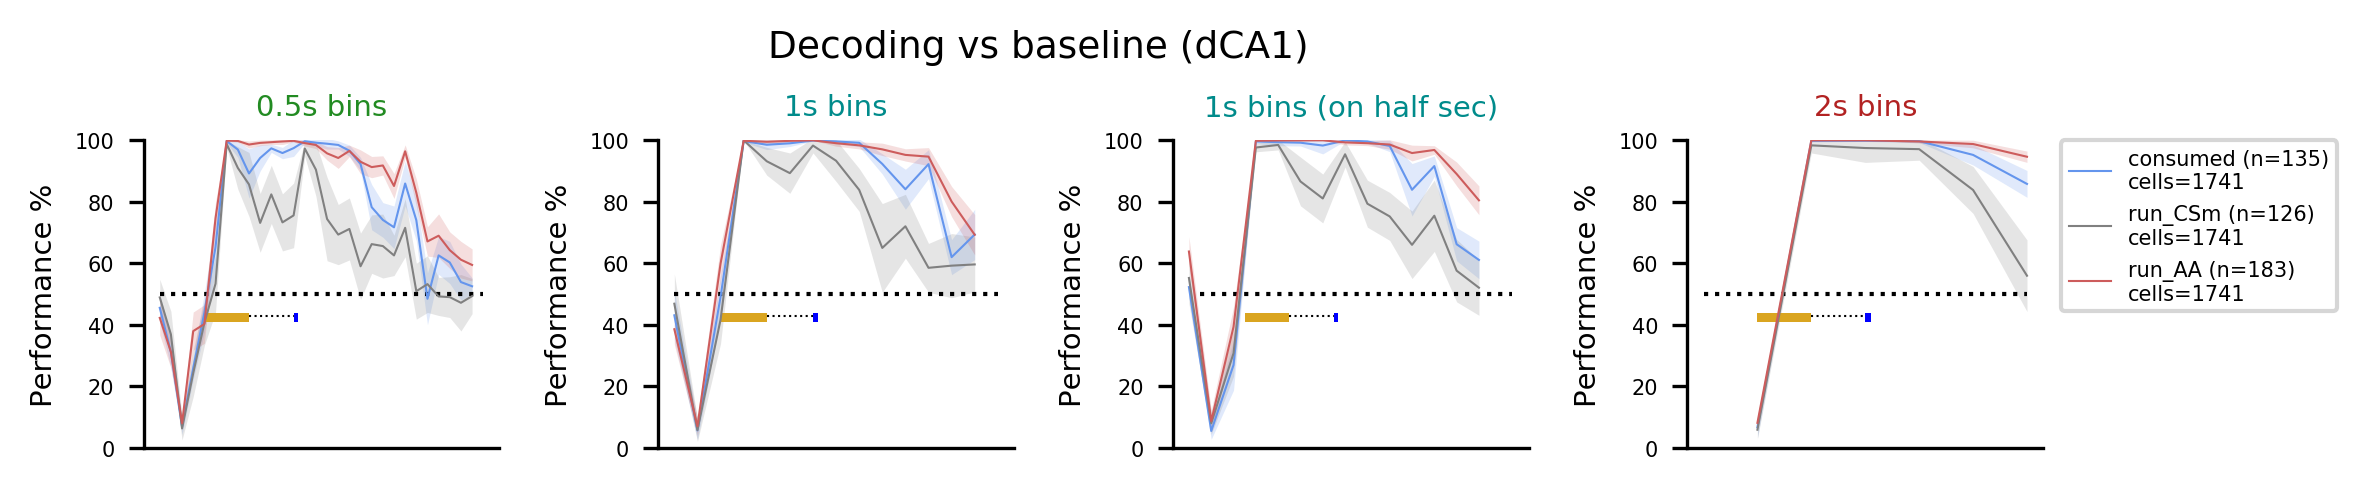

In [24]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c,la in zip(['consumed','run_CSm','run_AA'],['cornflowerblue','grey','indianred'],
                     ['consumed (n='+str(total_consumed_trials_post)+")\ncells="+str(total_cells_consumed),
                      'run_CSm (n='+str(total_run_CSm_trials_post)+")\ncells="+str(total_cells_run_CSm),
                      'run_AA (n='+str(total_run_AA_trials_post)+")\ncells="+str(total_cells_run_AA)]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_run.jpg'%NOTEBOOK_NAME)

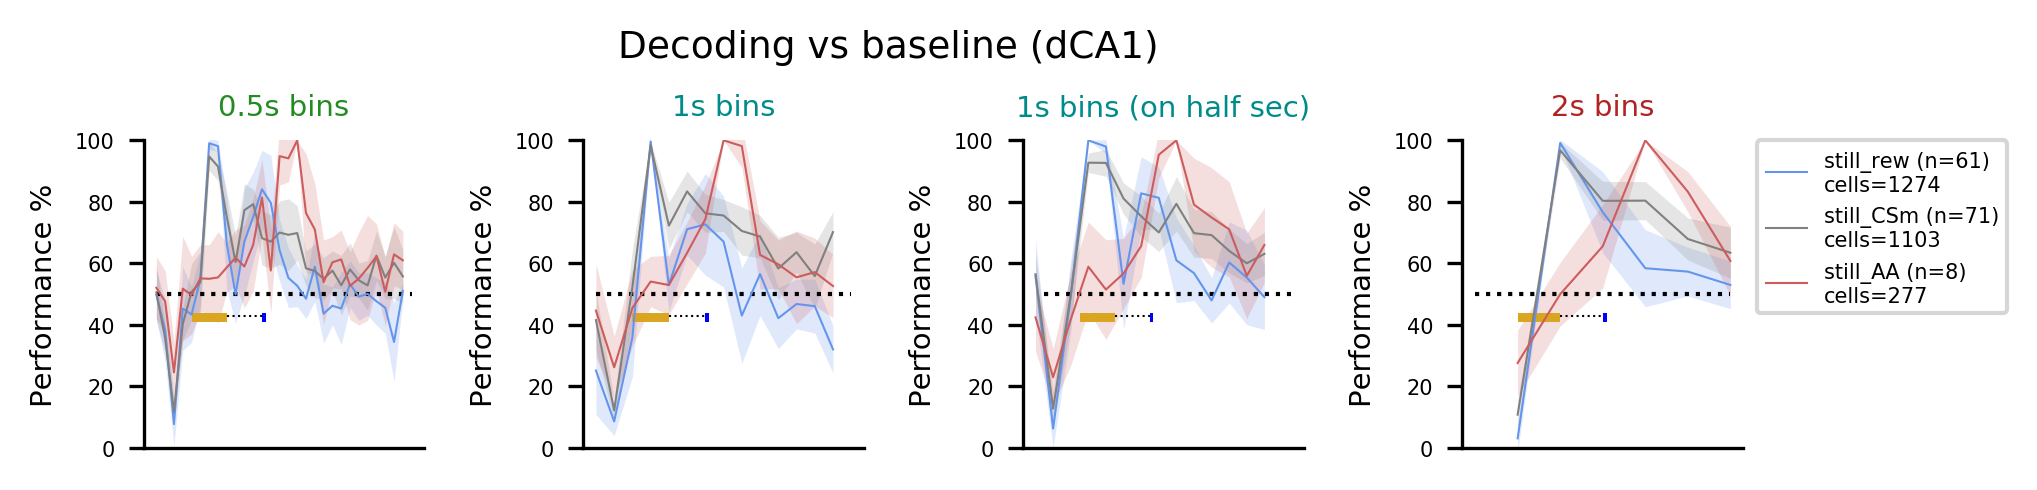

In [25]:
fig, ax = pl.subplots(1,4, figsize=(6, 1.5))

for comp,c,la in zip(['still_rew','still_CSm','still_AA'],['cornflowerblue','grey','indianred'],
                     ['still_rew (n='+str(total_still_rew_trials_post)+")\ncells="+str(total_cells_still_rew),
                      'still_CSm (n='+str(total_still_CSm_trials_post)+")\ncells="+str(total_cells_still_CSm),
                      'still_AA (n='+str(total_still_AA_trials_post)+")\ncells="+str(total_cells_still_AA)]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_still.jpg'%NOTEBOOK_NAME)

# now decode each animal individually

In [26]:
#trial type labels:
#reward w/o eliciting sucrose = 1, rew eliciting reward but not collecting within 1.5s of delivery=+ = 4, rew w/ consumption = 5
#CSm w/o running > threshold= 2, CSm w/ running > threshold = 6
#AA shocked= 3, AA avoided shock (running > threshold) = 7

In [35]:
## use this from the decoding_around_onset nb (for a single animal) as a guide
from sklearn.svm import LinearSVC
decodor = LinearSVC()
from sklearn.model_selection import cross_val_score, LeaveOneOut

comparisons = [1,10],[2,20],[3,30],[4,40],[5,50],[6,60],[7,70]
comparison_labels='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for sess in 'post',:
            for compare,comp_lab in zip(comparisons, comparison_labels):
                exec("individ_scores_%s_%s_%s_%s = {}"%(comp_lab,tb,sess,t))
                for ani in eval("patterns_%s_%s_%s_w_baselines.keys()"%(tb,sess,t)):
                    #try:
                        if sum(eval("labels_%s_w_baselines[ani]"%sess)==compare[0])>=5:
                            eval("individ_scores_%s_%s_%s_%s"%(comp_lab,tb,sess,t))[ani]=[]
                            exec("which_trials = (labels_%s_w_baselines[ani]==compare[0], labels_%s_w_baselines[ani]==compare[1])"%(sess,sess)) # make 2 arrays
                            which_trials = which_trials[0]+which_trials[1] #add arrays
                            eval("individ_scores_%s_%s_%s_%s"%(comp_lab,tb,sess,t))[ani] = np.r_[[(cross_val_score(decodor,
                              eval("patterns_%s_%s_%s_w_baselines[ani]"%(tb,sess,t))[which_trials], eval("labels_%s_w_baselines[ani]"%sess)[which_trials],
                                 cv=LeaveOneOut()))]]
                            #print '%s_%s_%s_%s_%s Done'%(comp_lab,tb,sess,t,ani),
                        else:
                            print '%s_%s_%s_%s_%s NOPE'%(comp_lab,tb,sess,t,ani),

still_rew_05s_post_0_dhpc37 NOPE still_CSm_05s_post_0_dhpc37 NOPE still_CSm_05s_post_0_dNAc3 NOPE still_AA_05s_post_0_dhpc40b NOPE still_AA_05s_post_0_dhpc37 NOPE still_AA_05s_post_0_dNAc3 NOPE still_AA_05s_post_0_dhpc40 NOPE not_consumed_05s_post_0_dhpc40b NOPE not_consumed_05s_post_0_dhpc37 NOPE not_consumed_05s_post_0_dNAc3 NOPE not_consumed_05s_post_0_dhpc40 NOPE not_consumed_05s_post_0_dhpc39 NOPE still_rew_05s_post_1_dhpc37 NOPE still_CSm_05s_post_1_dhpc37 NOPE still_CSm_05s_post_1_dNAc3 NOPE still_AA_05s_post_1_dhpc40b NOPE still_AA_05s_post_1_dhpc37 NOPE still_AA_05s_post_1_dNAc3 NOPE still_AA_05s_post_1_dhpc40 NOPE not_consumed_05s_post_1_dhpc40b NOPE not_consumed_05s_post_1_dhpc37 NOPE not_consumed_05s_post_1_dNAc3 NOPE not_consumed_05s_post_1_dhpc40 NOPE not_consumed_05s_post_1_dhpc39 NOPE still_rew_05s_post_2_dhpc37 NOPE still_CSm_05s_post_2_dhpc37 NOPE still_CSm_05s_post_2_dNAc3 NOPE still_AA_05s_post_2_dhpc40b NOPE still_AA_05s_post_2_dhpc37 NOPE still_AA_05s_post_2_dNAc3

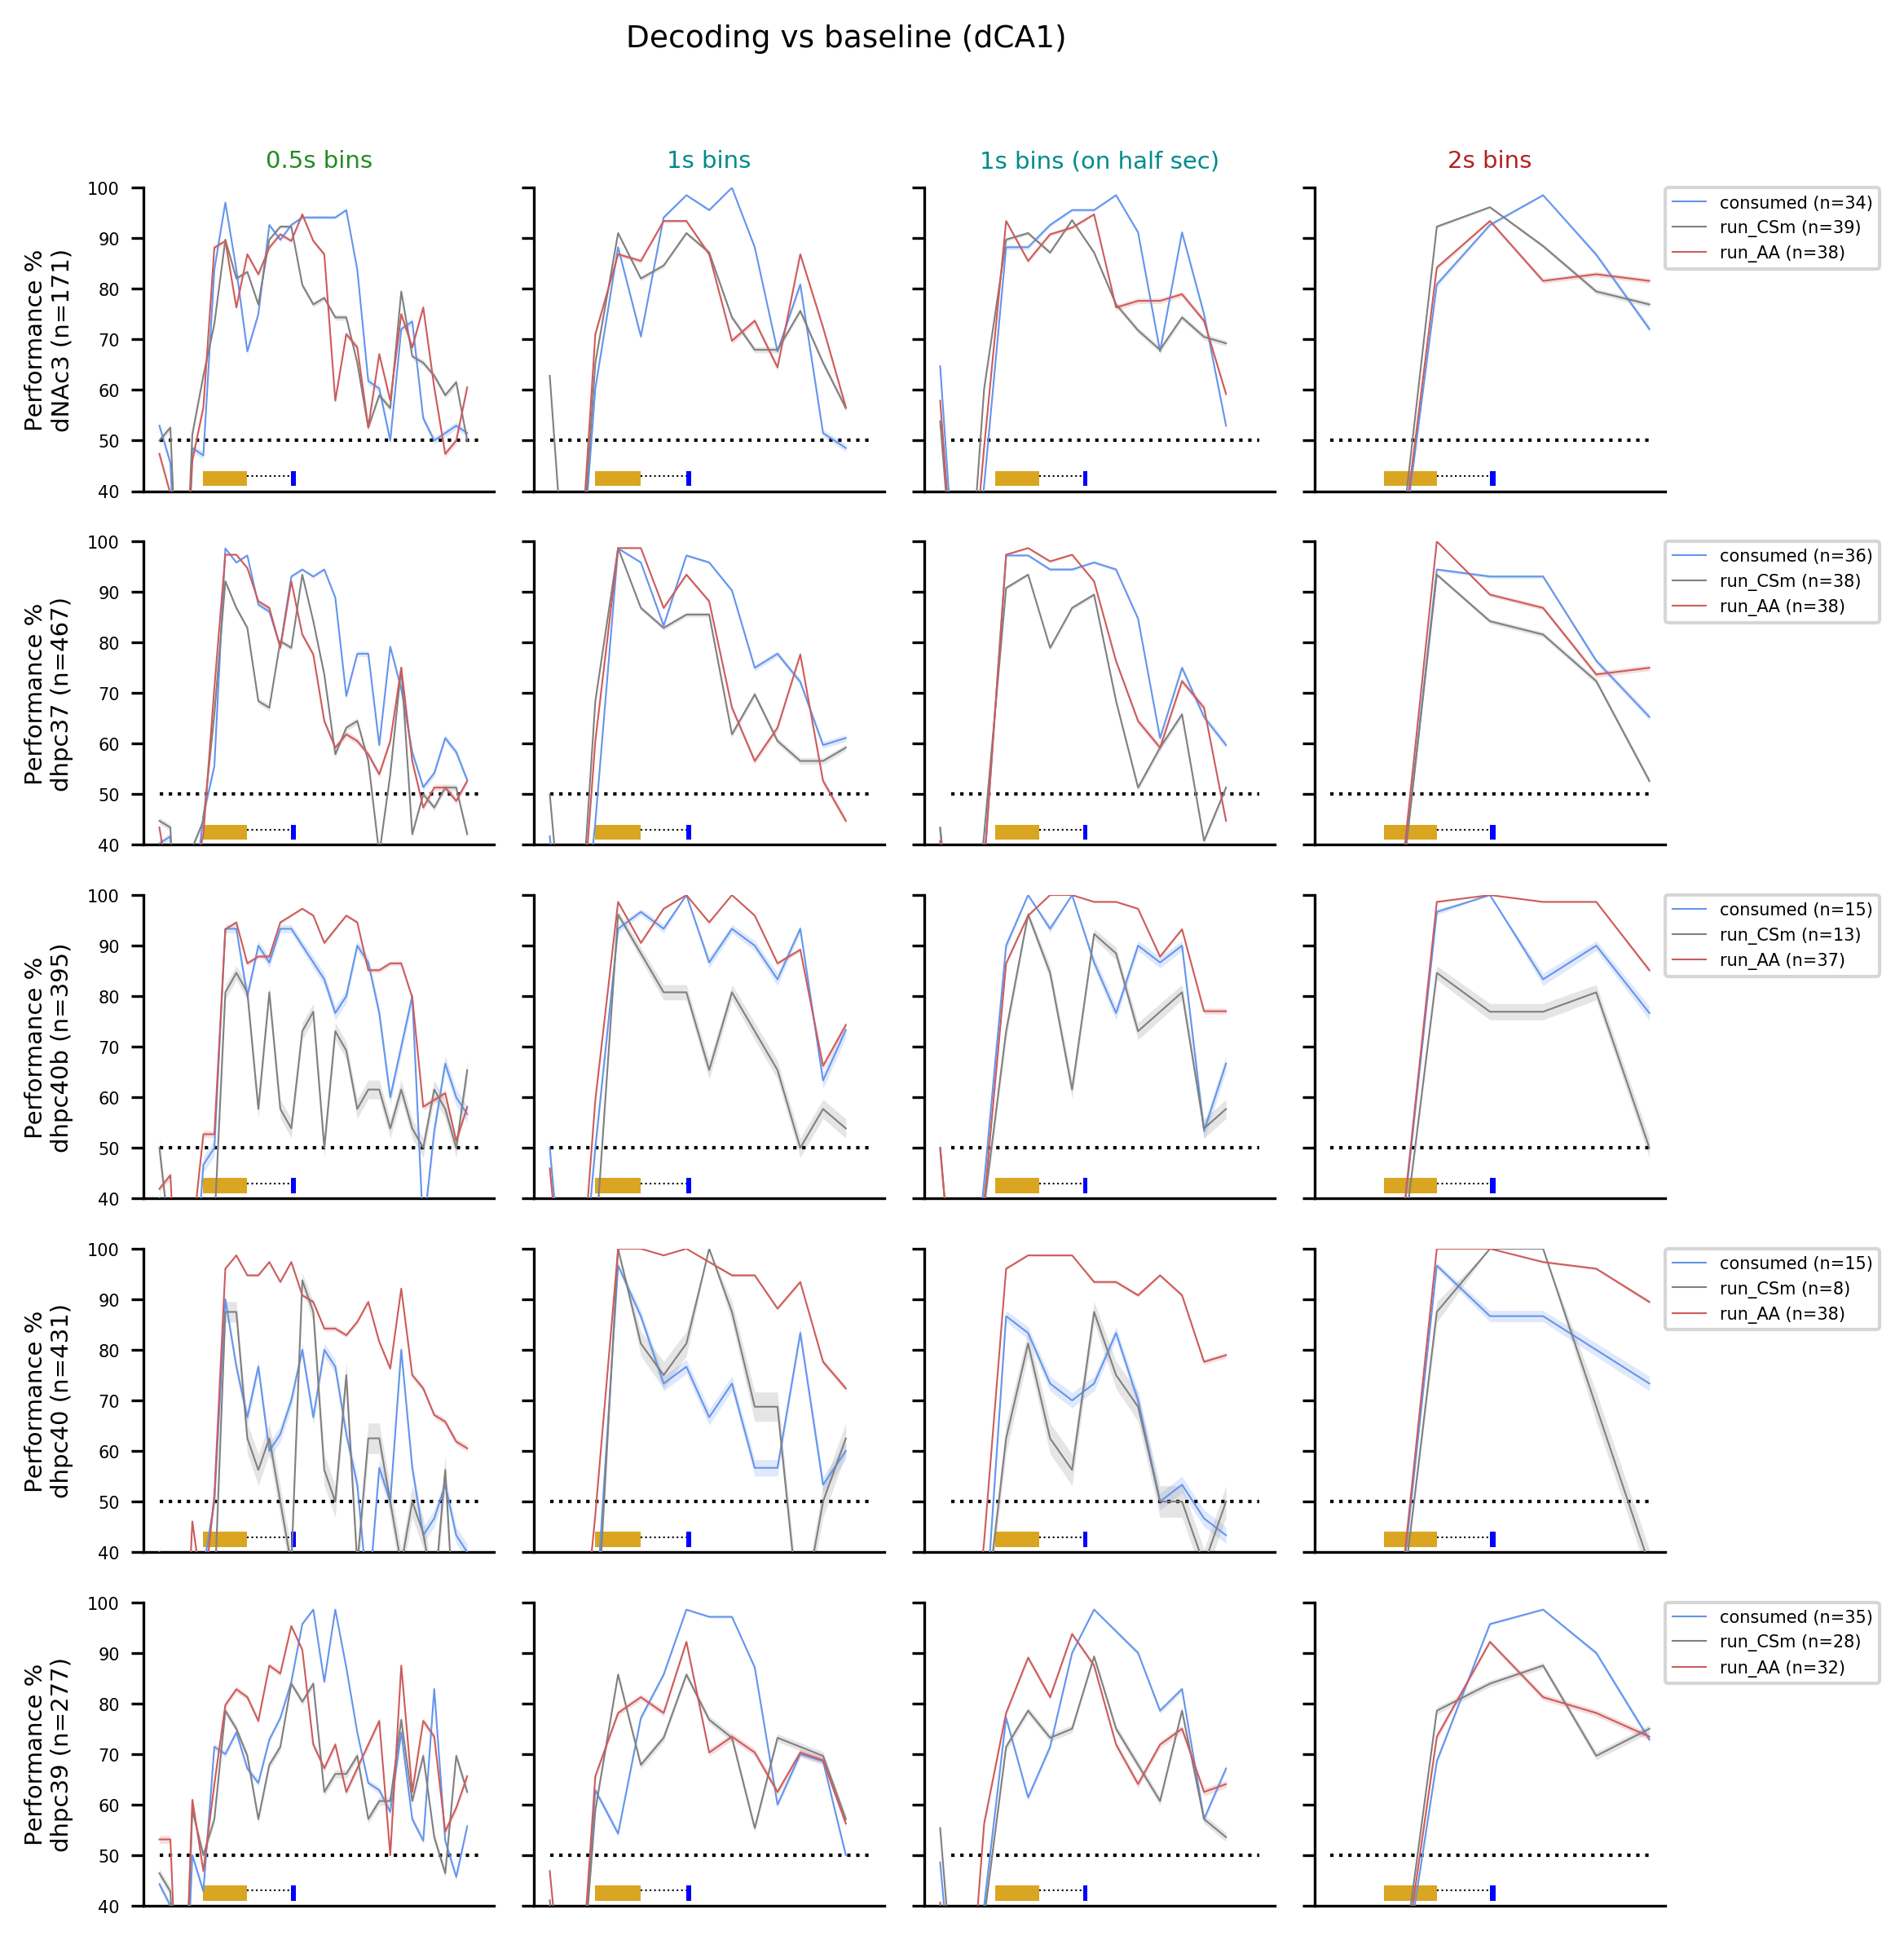

In [36]:
ses = 'post'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))),sharey=True)

for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,la in zip(['consumed','run_CSm','run_AA'],['cornflowerblue','grey','indianred'],
                     ['consumed (n='+str(np.sum(eval("labels_%s[key]==5"%ses)))+")",
                      'run_CSm (n='+str(np.sum(eval("labels_%s[key]==6"%ses)))+")",
                      'run_AA (n='+str(np.sum(eval("labels_%s[key]==7"%ses)))+")"]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
                m = np.array([(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,sess,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t)))/(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[0][3].set_title('2s bins', color = dark_co[2])
pl.suptitle("Decoding vs baseline (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_run_individ.jpg'%NOTEBOOK_NAME)

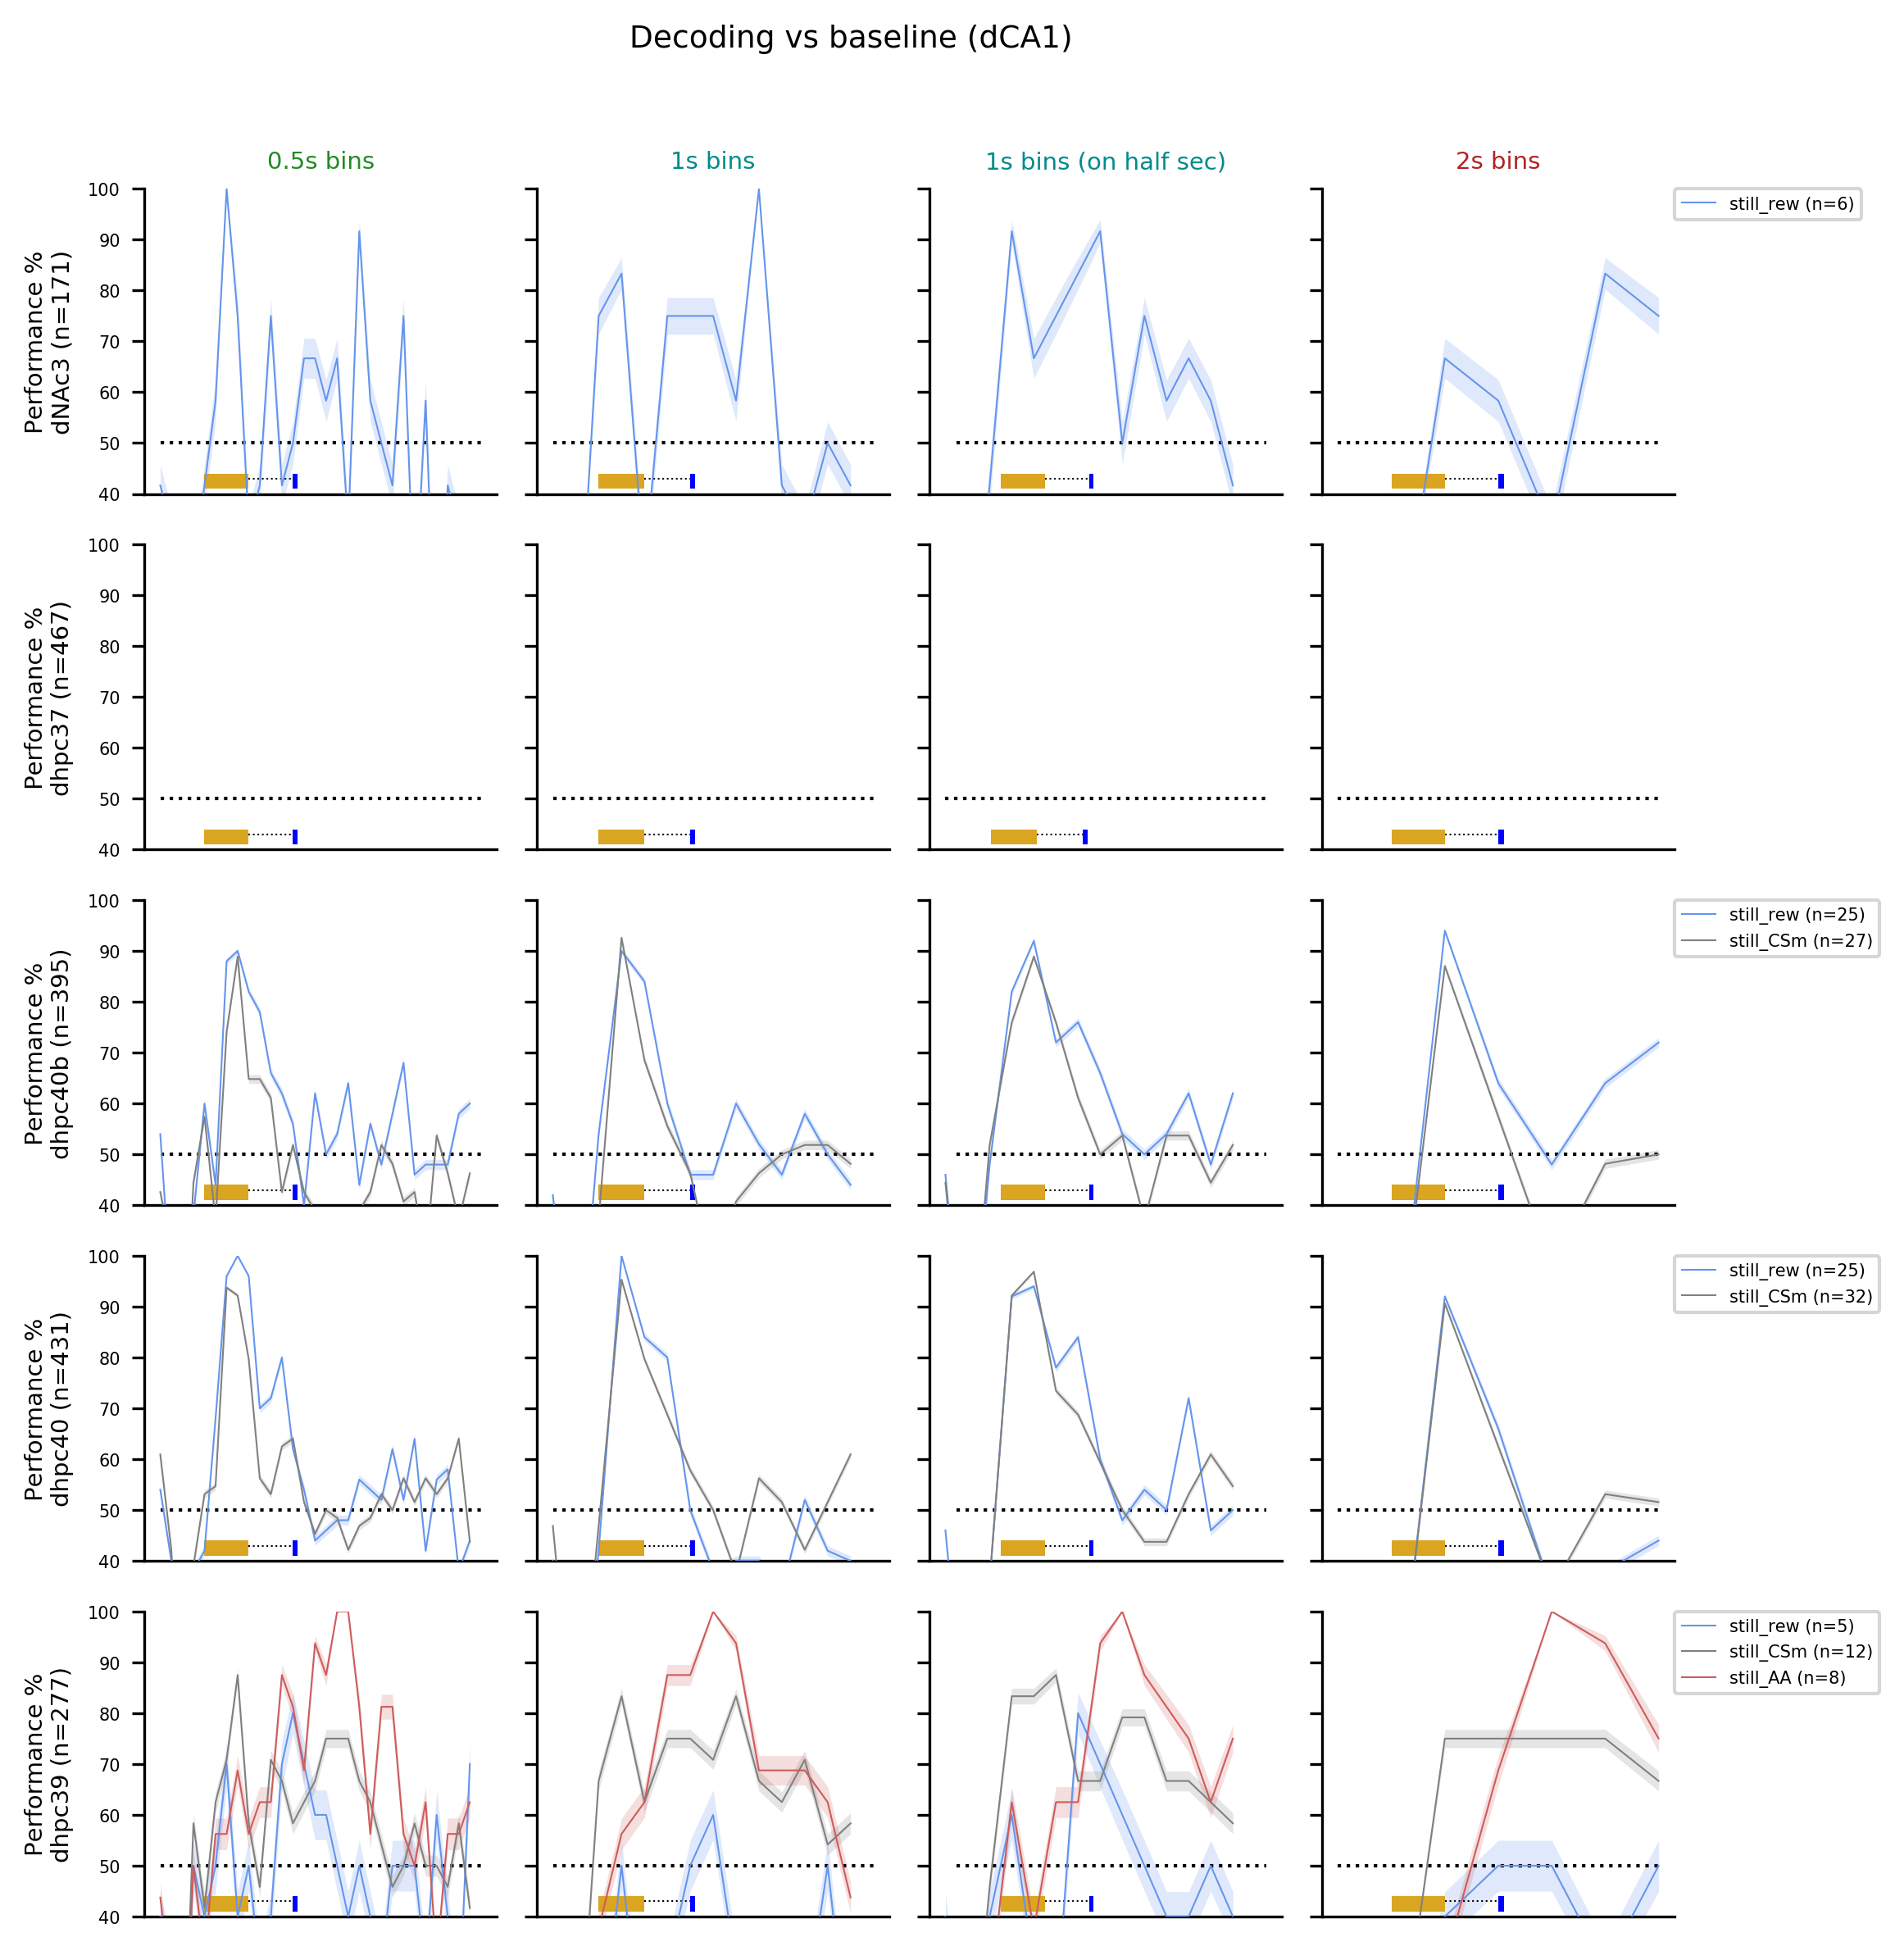

In [46]:
ses = 'post'
fig, ax = pl.subplots(len(eval("labels_%s.keys()"%ses)),4, figsize=(7, 1.5*len(eval("labels_%s.keys()"%ses))),sharey=True)

for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        for comp,c,la in zip(['still_rew','still_CSm','still_AA'],['cornflowerblue','grey','indianred'],
                     ['still_rew (n='+str(np.sum(eval("labels_%s[key]==1"%ses)))+")",
                      'still_CSm (n='+str(np.sum(eval("labels_%s[key]==2"%ses)))+")",
                      'still_AA (n='+str(np.sum(eval("labels_%s[key]==3"%ses)))+")"]):
            try:
                ax[y][r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t,)))*100) for t in range(bin_ranges[r])],
                           color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
                m = np.array([(np.mean(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t)))*100) for t in range(bin_ranges[r])])
                #s = np.array([np.std(eval("individ_scores_%s_%s_%s_%s['c18m9']"%(comp,tb,sess,t,)))*100 for t in range(bin_ranges[r])])
                SEM = np.array([(np.std(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t)))/(eval("individ_scores_%s_%s_%s_%s[key]"%(comp,tb,sess,t)).shape[1]))*100 for t in range(bin_ranges[r])])
                ax[y][r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-SEM,m+SEM,alpha=0.2,color=c,linewidth=0)
                ax[y][3].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
            except:
                continue
for x,tick in zip(range(4),[2,1,1,.5]):
    for y,key in zip(range(len(eval("labels_%s.keys()"%ses))),eval("labels_%s.keys()"%ses)):
        ax[y][x].set_ylim(40, 100)
        #ax[y][x].set_xlim(-3, bin_ranges[x])
        #ax[y][x].set_xticks(np.arange(-2,11, 1))
        #ax[y][x].set_xticklabels(np.arange(-2,11, .5))
        ax[y][x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
        #ax[y][x].set_xlabel('Time from odor onset (s)')
        ax[y][0].set_ylabel('Performance %\n'+key+" (n="+str(eval("patterns_1s_%s[key].shape[-1]"%ses))+")")
        pt.plot_period_bar(ax[y][x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
        pt.plot_period_bar(ax[y][x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
        ax[y][x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
        ax[y][x].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
ax[0][0].set_title('0.5s bins', color=dark_co[0])
ax[0][1].set_title('1s bins', color = dark_co[1])
ax[0][2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[0][3].set_title('2s bins', color = dark_co[2])
pl.suptitle("Decoding vs baseline (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_still_individ.jpg'%NOTEBOOK_NAME)

# Now for equalizing cell #s across all sess by using min

In [66]:
%%time
n_loops=20
classes = [1,10],[2,20],[3,30],[4,40],[5,50],[6,60],[7,70]
comparison_labels='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'
for tb,i in zip(bins,range(len(bins))):
    for t in range(bin_ranges[i]): # number of time bins
        for cl,comp_la in zip(classes,comparison_labels):
            exec('baseline_scores_gmin_%s_%s_%s = {}'%(tb,t,comp_la))
            for sess in 'post',:
                print sess,t,comp_la,
                try:
                    eval("baseline_scores_gmin_%s_%s_%s"%(tb,t,comp_la))[sess] = np.r_[[do_test_within(eval("patterns_%s_%s_%s_w_baselines"%(tb,sess,t)),
                        eval("labels_%s_w_baselines"%sess),classes=cl, n_cells=340, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',

post 0 still_rew post 0 still_CSm post 0 still_AA post 0 not_consumed NOPE post 0 consumed post 0 run_CSm post 0 run_AA post 1 still_rew post 1 still_CSm post 1 still_AA post 1 not_consumed NOPE post 1 consumed post 1 run_CSm post 1 run_AA post 2 still_rew post 2 still_CSm post 2 still_AA post 2 not_consumed NOPE post 2 consumed post 2 run_CSm post 2 run_AA post 3 still_rew post 3 still_CSm post 3 still_AA post 3 not_consumed NOPE post 3 consumed post 3 run_CSm post 3 run_AA post 4 still_rew post 4 still_CSm post 4 still_AA post 4 not_consumed NOPE post 4 consumed post 4 run_CSm post 4 run_AA post 5 still_rew post 5 still_CSm post 5 still_AA post 5 not_consumed NOPE post 5 consumed post 5 run_CSm post 5 run_AA post 6 still_rew post 6 still_CSm post 6 still_AA post 6 not_consumed NOPE post 6 consumed post 6 run_CSm post 6 run_AA post 7 still_rew post 7 still_CSm post 7 still_AA post 7 not_consumed NOPE post 7 consumed post 7 run_CSm post 7 run_AA post 8 still_rew post 8 still_CSm post 8

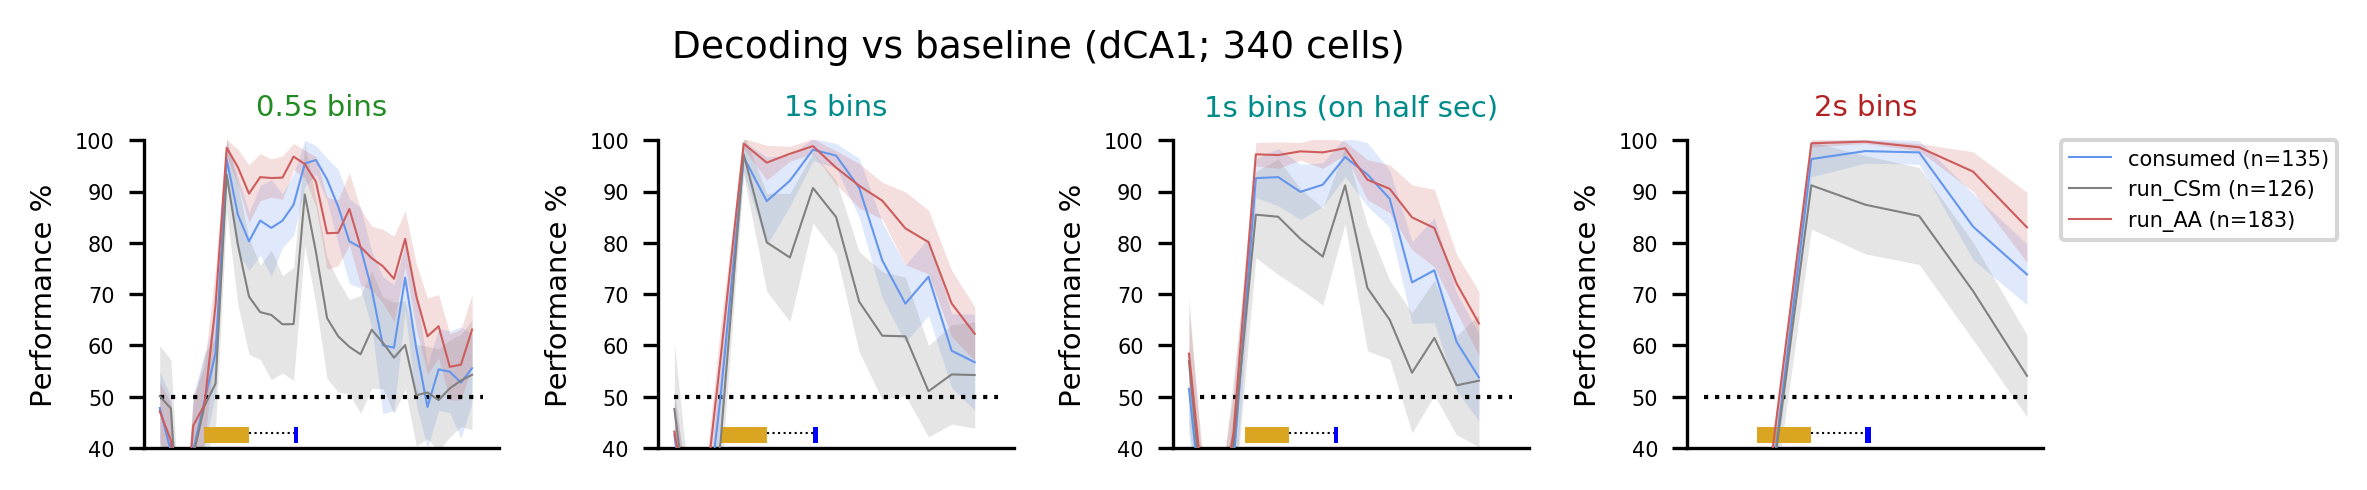

In [67]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c,la in zip(['consumed','run_CSm','run_AA'],['cornflowerblue','grey','indianred'],
                     ['consumed (n='+str(total_consumed_trials_post)+")",
                      'run_CSm (n='+str(total_run_CSm_trials_post)+")",
                      'run_AA (n='+str(total_run_AA_trials_post)+")"]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
        s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
        ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1; 340 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_run_gmin.jpg'%NOTEBOOK_NAME)

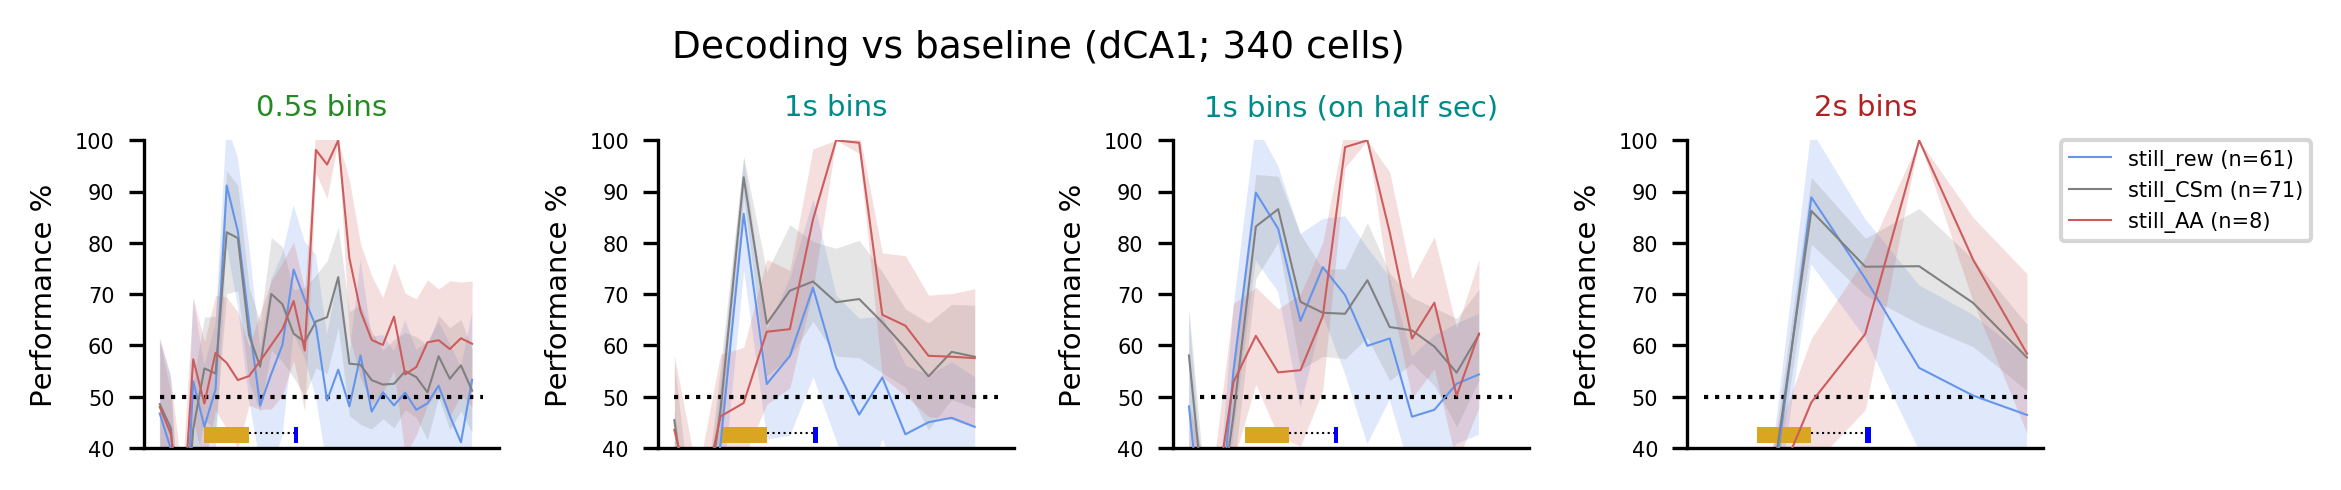

In [68]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c,la in zip(['still_rew','still_CSm','still_AA'],['cornflowerblue','grey','indianred'],
                     ['still_rew (n='+str(total_still_rew_trials_post)+")",
                      'still_CSm (n='+str(total_still_CSm_trials_post)+")",
                      'still_AA (n='+str(total_still_AA_trials_post)+")"]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_gmin_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(40, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1; 340 cells)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_still_gmin.jpg'%NOTEBOOK_NAME)

## only use high performers (HP)

In [69]:
def combine_train_test_patterns_num_trials_HP(patterns, labels, num_trials, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    for ani in patterns.keys():
        if ani in high_performing_animals:
        #only analyze if have > 5 trials of each trial type
            if (np.shape(np.where(labels[ani]==classes[0]))[-1]>=5) and (np.shape(np.where(labels[ani]==classes[1]))[-1]>=5): #only include animal if it has x trials of specified trial type
                which_trains = []
                which_tests = []
                #find min number of trials of both trial types, then downsample the type with more trials to match min
                #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
                min_trials1=np.sum(labels[ani]==classes[0])
                min_trials2=np.sum(labels[ani]==classes[1])
                min_trials=min(min_trials1,min_trials2)
                if min_trials < num_trials:
                    print ani,"trials:",min_trials,"   ",
                for l in classes:
                    if l>=0:
                        wt = np.random.permutation(np.where(labels[ani]==l)[0])[:min_trials]
                        # constrain number of trials to be consistent across conditions
                        wt = wt[:num_trials]
                        if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                            wT = wt[:int(len(wt)*train_test_split)]
                            which_trains.append(wt[int(len(wt)*train_test_split):])
                            which_tests.append(wT)
                        else:
                            which_trains.append(wt)
                which_train[ani] = np.concatenate(which_trains)
                if train_test_split<1:
                    which_test[ani] = np.concatenate(which_tests)
            else:
                not_run.append(ani)
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        #patterns_t[ani] = patterns[ani].copy()
        #labels_t[ani] = labels[ani].copy()
        #print which_train.keys()
    #for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
    #    print ani
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            #patterns_T[ani] = patterns[ani].copy()
            #labels_T[ani] = labels[ani].copy()
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells)
    
def do_test_within_num_trials_HP(patterns, labels, num_trials, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns_num_trials_HP(patterns, labels, num_trials, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def Not_Run_HP(patterns, labels, num_trials, **args):
    x, y, xT, yT,not_run,which_cells = combine_train_test_patterns_num_trials_HP(patterns, labels, num_trials, **args)
    return not_run,sum(which_cells)

In [74]:
%%time
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40],[5,50],[6,60],[7,70]
comparison_labels='still_rew','still_CSm','still_AA','not_consumed','consumed','run_CSm','run_AA'

for cl,comp_la in zip(classes,comparison_labels):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('baseline_scores_HP_%s_%s_%s = {}'%(tb,t,comp_la))
            for sess in 'post',:
                print sess,t,comp_la,
                try:
                    eval("baseline_scores_HP_%s_%s_%s"%(tb,t,comp_la))[sess] = np.r_[[do_test_within_num_trials_HP(eval("patterns_%s_%s_%s_w_baselines"%(tb,sess,t)),
                        eval("labels_%s_w_baselines"%sess),num_trials=20,classes=cl, n_cells=260, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',
    try:
        exec("not_run_HP,total_cells_%s_HP = Not_Run_HP(patterns_%s_%s_%s_w_baselines,labels_%s_w_baselines,num_trials=20,classes=cl, n_cells=None,\
              relabel=None)"%(comp_la,tb,sess,t,sess))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run_HP
        print "total cells =",eval("total_cells_%s_HP"%(comp_la))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
        exec("total_cells_%s_HP=0"%(comp_la))
        
    for key in labels_post_w_baselines.keys():
        if key in high_performing_animals:
            v0=0
            for val in labels_post_w_baselines[key]:
                if val == cl[0]:
                    v0 += 1
            exec("vals_%s =v0"%key)
            #print "animal %s="%key,eval("vals_%s"%key),"trials"
    sum_vals=0
    for key in labels_post_w_baselines.keys():
        if key in high_performing_animals:
            if eval("vals_%s"%key)>=5:
                sum_vals = sum_vals + eval("vals_%s"%key)
    exec("total_%s_trials_post_HP = sum_vals"%(comp_la))
    print "total_%s_trials_post_HP ="%(comp_la),eval("total_%s_trials_post_HP"%(comp_la)),"\n"

post 0 still_rew dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     post 1 still_rew dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhpc39 trials: 5     dNAc3 trials: 6     dhp

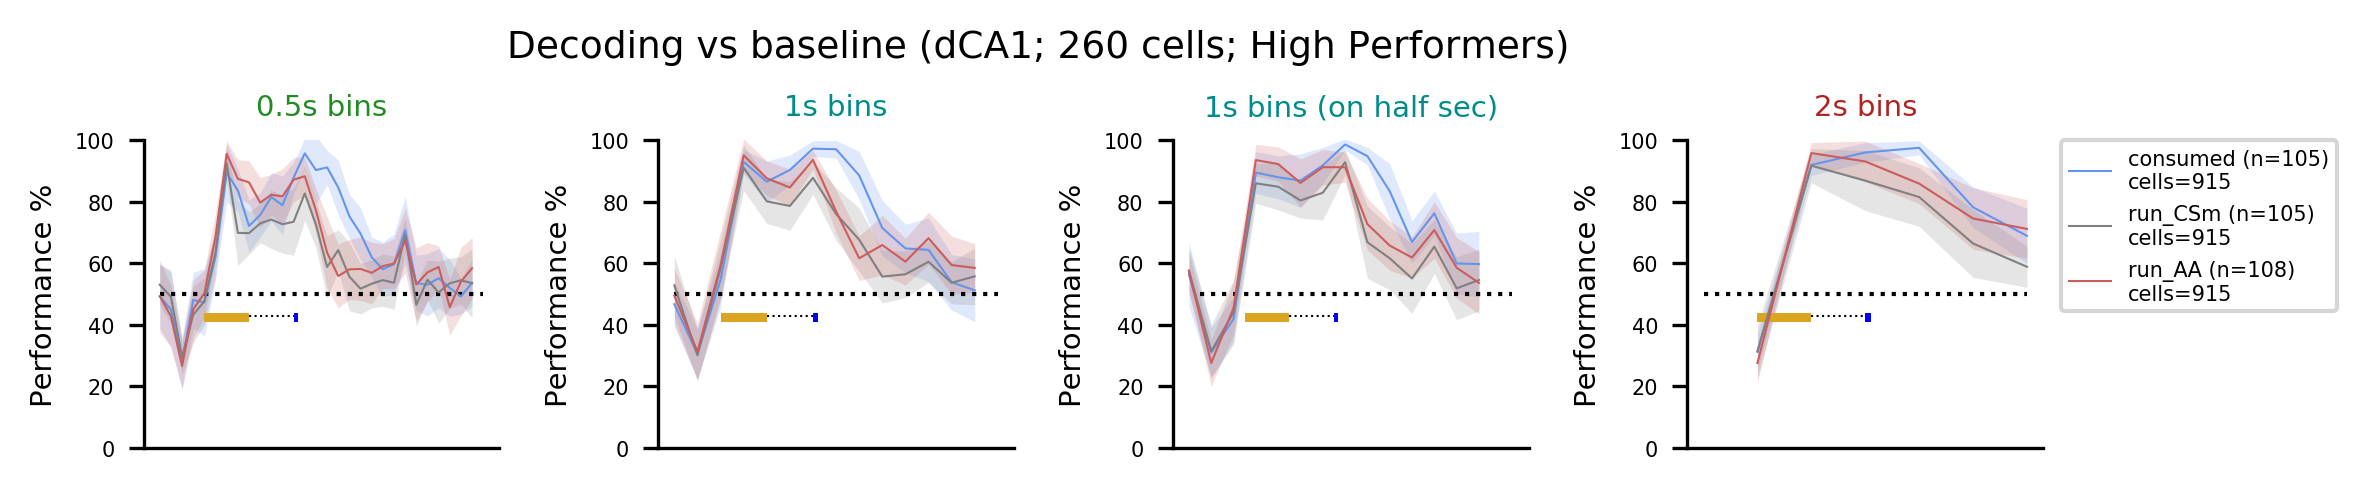

In [75]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c,la in zip(['consumed','run_CSm','run_AA'],['cornflowerblue','grey','indianred'],
                     ['consumed (n='+str(total_consumed_trials_post_HP)+")\ncells="+str(total_cells_consumed_HP),
                      'run_CSm (n='+str(total_run_CSm_trials_post_HP)+")\ncells="+str(total_cells_run_CSm_HP),
                      'run_AA (n='+str(total_run_AA_trials_post_HP)+")\ncells="+str(total_cells_run_AA_HP)]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_HP_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_HP_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_HP_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1; 260 cells; High Performers)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_run_gmin_HP.jpg'%NOTEBOOK_NAME)

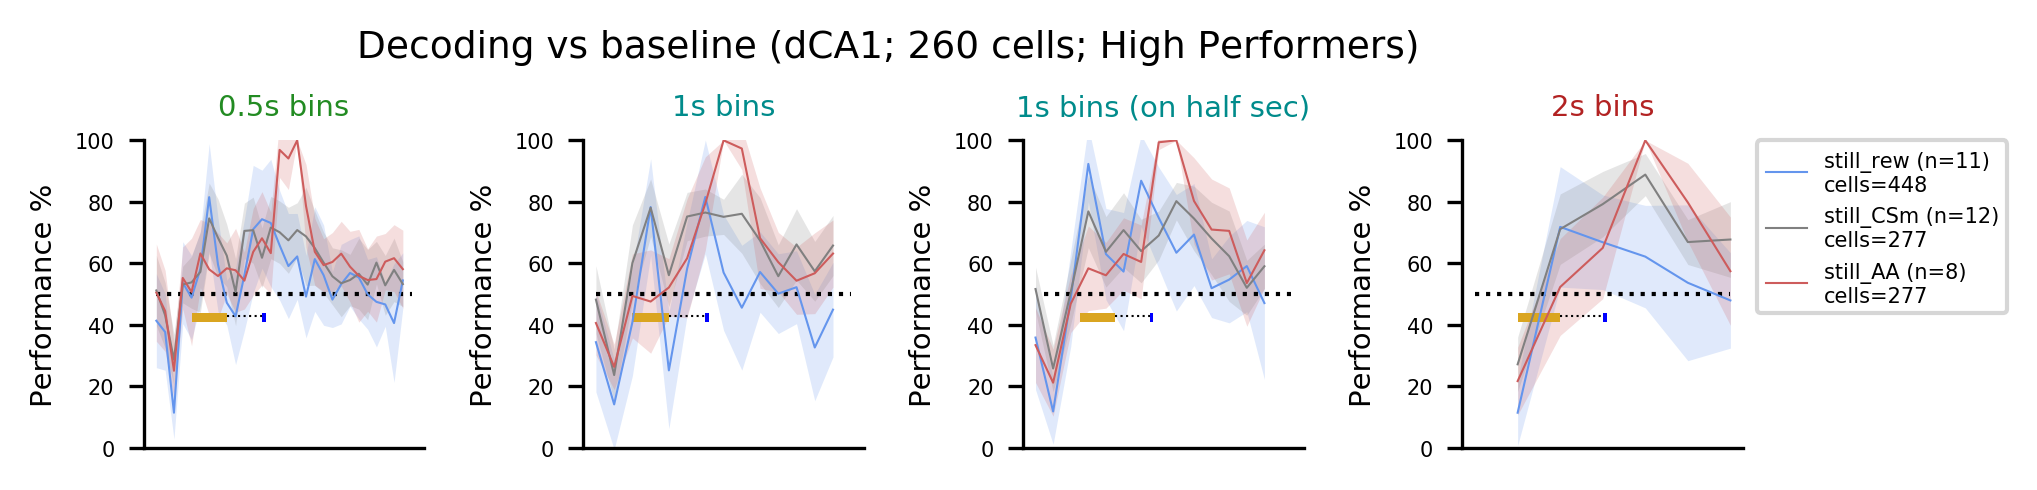

In [76]:
fig, ax = pl.subplots(1,4, figsize=(6, 1.5))

for comp,c,la in zip(['still_rew','still_CSm','still_AA'],['cornflowerblue','grey','indianred'],
                     ['still_rew (n='+str(total_still_rew_trials_post_HP)+")\ncells="+str(total_cells_still_rew_HP),
                      'still_CSm (n='+str(total_still_CSm_trials_post_HP)+")\ncells="+str(total_cells_still_CSm_HP),
                      'still_AA (n='+str(total_still_AA_trials_post_HP)+")\ncells="+str(total_cells_still_AA_HP)]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_HP_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_HP_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_HP_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1; 260 cells; High Performers)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

fig.savefig('../figures/%s_still_gmin_HP.jpg'%NOTEBOOK_NAME)

### only use trials where speed is similar (to control for diff speeds across trial types)

In [12]:
#import speeds and timings of odor onsets
for sess in sessions:
    for var in ['speed','speed_times','STIMs_ons','is_rewardedt','is_avoidedt','is_CSm_enabledt']:
        try:
            exec("%s_%s = dict(zip(%s_animals, [ut.load_variable('%s',\
                                                               '../%%s/%s/notebooks/autorestore/preprocessing/'%%ani)\
                                                      for ani in %s_animals]))"%(var,sess,sess,var,sess,sess))
        except:
            print 'nope %s %s'%(var,sess),

nope speed expo nope speed_times expo nope STIMs_ons expo nope is_rewardedt expo nope is_avoidedt expo nope is_CSm_enabledt expo nope speed pre nope speed_times pre nope STIMs_ons pre nope is_rewardedt pre nope is_avoidedt pre nope is_CSm_enabledt pre nope speed mid nope speed_times mid nope STIMs_ons mid nope is_rewardedt mid nope is_avoidedt mid nope is_CSm_enabledt mid


In [14]:
def combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    patterns_t={}
    patterns_T={}
    labels_t={}
    labels_T={}
    not_run=[]
    speed_patterns={}
    speed_labels={}
    tot_trials=0
    for ani in patterns.keys():
        #only keep trials where running avg is within window defined earlier
        speed_patterns[ani]=patterns[ani][speed[ani]]
        speed_labels[ani]=labels[ani][speed[ani]]
        #only analyze if have > 5 trials of each trial type
        if (sum(speed_labels[ani]==classes[0])>=3) and (sum(speed_labels[ani]==classes[1])>=3): #only include animal if it has x trials of specified trial type
            which_trains = []
            which_tests = []
            #find min number of trials of both trial types, then downsample the type with more trials to match min
            #need here to ensure you get the same# of trials for each type in the case where min# of trials for either is < num_trials
            min_trials1=np.sum(speed_labels[ani]==classes[0])
            min_trials2=np.sum(speed_labels[ani]==classes[1])
            min_trials=min(min_trials1,min_trials2)
            if min_trials < num_trials:
                print ani,"trials:",min_trials,"     ",
            tot_trials = tot_trials + min(min_trials,num_trials)
            for l in classes:
                if l>=0:
                    wt = np.random.permutation(np.where(speed_labels[ani]==l)[0])[:min_trials]
                    # constrain number of trials to be consistent across conditions
                    wt = wt[:num_trials]
                    if train_test_split<1: #split trials into train and test subsets (ratio set by "train_test_split" value)
                        wT = wt[:int(len(wt)*train_test_split)]
                        which_trains.append(wt[int(len(wt)*train_test_split):])
                        which_tests.append(wT)
                    else:
                        which_trains.append(wt)
            which_train[ani] = np.concatenate(which_trains)
            if train_test_split<1:
                which_test[ani] = np.concatenate(which_tests)
        else:
            not_run.append(ani)
    #find total number of trials used across all animals
    
    for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
        patterns_t[ani] = speed_patterns[ani][which_train[ani]]
        labels_t[ani] = speed_labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = combine_patterns(patterns_t, labels_t, classes=classes)

        
    if train_test_split<1:
        for ani in which_train.keys():   #only use animals that met trial type occurence criteria above
            patterns_T[ani] = speed_patterns[ani][which_test[ani]]
            labels_T[ani] = speed_labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
        
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0],not_run,which_cells,tot_trials)
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None,not_run,which_cells,tot_trials)
    
def do_test_within_num_trials_speed(patterns, labels, num_trials, speed, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed, **args)
    decoder.fit(x, y)
    #print "Not run:",not_run
    return decoder.score(xT, yT)

def Not_Run_speed(patterns, labels, num_trials, speed, **args):
    x, y, xT, yT,not_run,which_cells,tot_trials = combine_train_test_patterns_num_trials_speed(patterns, labels, num_trials, speed,**args)
    return not_run,len(which_cells),tot_trials

In [30]:
#get mean running speed for ~1s trace period prior to spout moving in
min_avg_speed = 9
max_avg_speed = 15
for sess in 'post',:
    #try:
        exec("mean_trace_speed_%s={}"%sess)
        exec("is_mean_speedt_%s={}"%sess)
        for ani in eval("speed_%s.keys()"%sess):
            exec("mean_trace_speed_%s[ani]=[]"%sess)
            exec("is_mean_speedt_%s[ani]=[]"%sess)
            for i, stim_ons in enumerate(eval("STIMs_ons_%s[ani]"%sess)):
                #only get data points during trace period before spout moved in
                exec("speed_filt = ((speed_times_%s[ani]-stim_ons)>2.5) * ((speed_times_%s[ani]-stim_ons)<3.4)"%(sess,sess))
                exec("mean = np.mean(np.r_[speed_%s[ani]][speed_filt])"%(sess))
                eval("mean_trace_speed_%s[ani].append(mean)"%(sess))
            for x in eval("mean_trace_speed_%s[ani]"%sess):
                eval("is_mean_speedt_%s[ani].append(min_avg_speed <= x <= max_avg_speed)"%sess)
            #finally, concatenate list with itself to account for the doubling of pattern array we had to do for baseline data
            eval("is_mean_speedt_%s[ani].extend(is_mean_speedt_%s[ani])"%(sess,sess))
    #except:
    #    print 'NOPE %s' %sess

In [31]:
%%time
#get train and test subsamples for each timebin, for each session
n_loops=15
num_trials=10
classes_speed =[5,50],[6,60],[7,70]
comparisons_speed='consumed','run_CSm','run_AA'
for cl,comp_la in zip(classes_speed,comparisons_speed):
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('baseline_scores_speed_%s_%s_%s = {}'%(tb,t,comp_la))
            for sess in 'post',:
                print sess,t,comp_la,
                try:
                    eval("baseline_scores_speed_%s_%s_%s"%(tb,t,comp_la))[sess] = np.r_[[do_test_within_num_trials_speed(eval("patterns_%s_%s_%s_w_baselines"%(tb,sess,t)),
                        eval("labels_%s_w_baselines"%sess),num_trials=num_trials,speed=eval("is_mean_speedt_%s"%sess),classes=cl,
                                                                        n_cells=260, relabel=None) for i in range(n_loops)]]
                except:
                    print 'NOPE',
    #for tb,i in zip(bins,range(len(bins))):
    #    for t in range(bin_ranges[i]): # number of time bins
    #        exec('scores_gmins_speed_%s_%s_%s_vs_%s = {}'%(tb,t,comp[0],comp[1]))
    #        for sess in 'post',:
    #            print sess,t,comp[0],comp[1],
    #            #try:
    #            eval("scores_gmins_speed_%s_%s_%s_vs_%s"%(tb,t,comp[0],comp[1]))[sess] = \
    #                np.r_[[do_test_within_num_trials_speed(eval("patterns_%s_%s_%s"%(tb,sess,t)),
    #                    eval("labels_%s"%(sess)),num_trials=num_trials, speed=eval("is_mean_speedt_%s"%sess),classes=cl,
    #                    n_cells=260, relabel=None) for i in range(n_loops)]]
    #            #except:
    #            #    print 'NOPE'
    #            
    try:
        exec("not_run_speed,total_cells_speed_%s,tot_trials_speed_%s = Not_Run_speed(patterns_%s_%s_%s_w_baselines,labels_%s_w_baselines,num_trials=num_trials,\
        speed=is_mean_speedt_%s,classes=cl, n_cells=None,relabel=None)"%(comp_la,comp_la,tb,sess,t,sess,sess))
        print "\n\nNOT INCLUDED IN ANALYSIS (too few trials):",not_run_speed
        print "total cells =",eval("total_cells_speed_%s"%(comp_la))
    except:
        print "\nNO ANIMALS MET CRITERIA (all had too few trials)"
    print "Total Trials = ",eval("tot_trials_speed_%s"%(comp_la))

post 0 consumed dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       post 1 consumed dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       post 2 consumed dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 5       dhpc40b trials: 

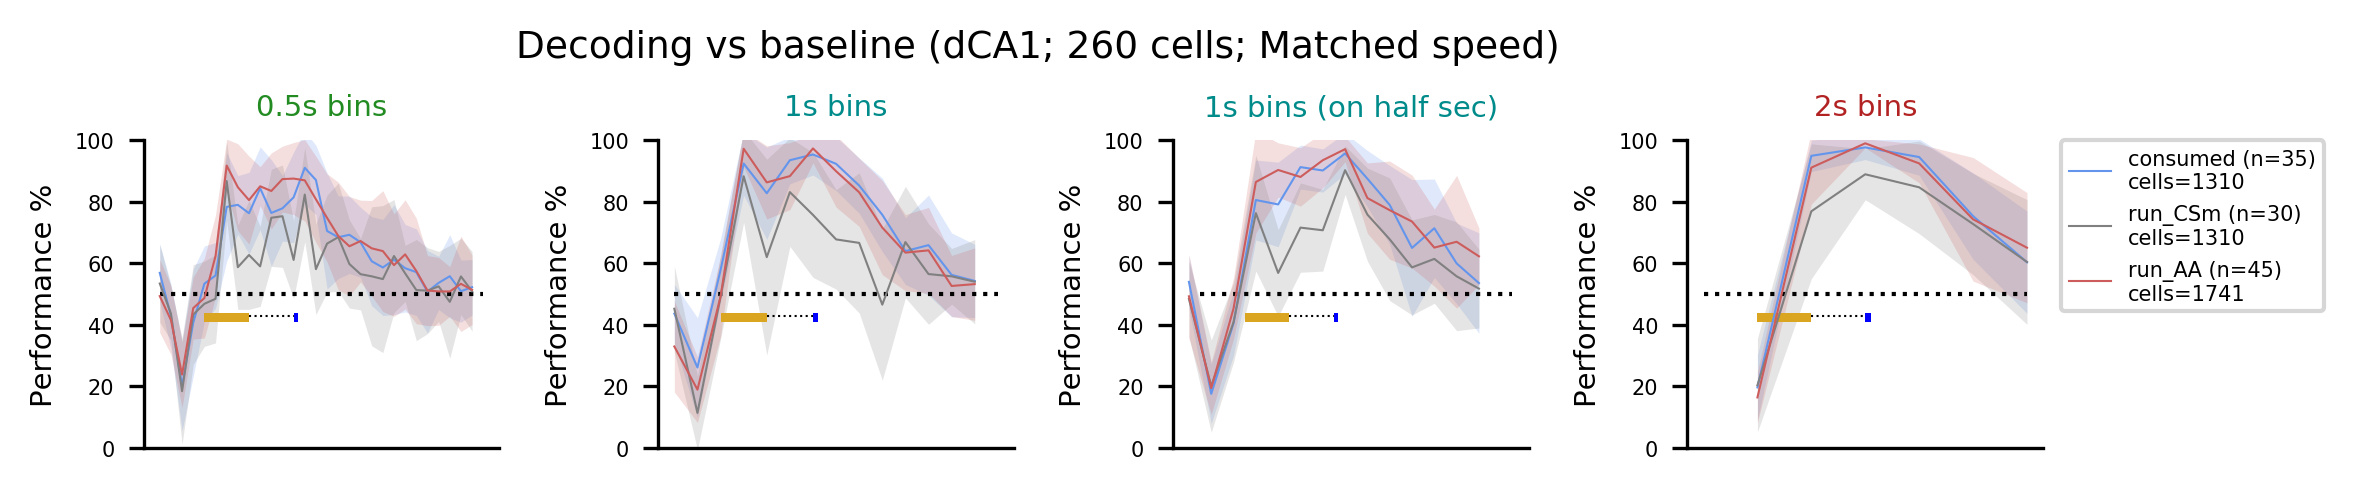

In [32]:
fig, ax = pl.subplots(1,4, figsize=(7, 1.5))

for comp,c,la in zip(['consumed','run_CSm','run_AA'],['cornflowerblue','grey','indianred'],
                     ['consumed (n='+str(tot_trials_speed_consumed)+")\ncells="+str(total_cells_speed_consumed),
                      'run_CSm (n='+str(tot_trials_speed_run_CSm)+")\ncells="+str(total_cells_speed_run_CSm),
                      'run_AA (n='+str(tot_trials_speed_run_AA)+")\ncells="+str(total_cells_speed_run_AA)]):
    for r,tb,sub in zip(range(4),bins,[4,2,2.5,0]):
        try:
            ax[r].plot([(t-sub) for t in range(bin_ranges[r])], [(np.mean(eval("baseline_scores_speed_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])],
                       color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
            m = np.array([(np.mean(eval("baseline_scores_speed_%s_%s_%s['post']"%(tb,t,comp)))*100) for t in range(bin_ranges[r])])
            s = np.array([np.std(eval("baseline_scores_speed_%s_%s_%s['post']"%(tb,t,comp)))*100 for t in range(bin_ranges[r])])
            ax[r].fill_between([(t-sub) for t in range(bin_ranges[r])],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        except:
            continue
for x,tick in zip(range(4),[2,1,1,.5]):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-3, bin_ranges[x])
    #ax[x].set_xticks(np.arange(-2,11, 1))
    #ax[x].set_xticklabels(np.arange(-2,11, .5))
    ax[x].hlines(50, -2*tick,bin_ranges[x]-2*tick, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 41, start_end=(0, 2*tick), color='goldenrod', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 41, start_end=(4*tick, 4.2*tick), color='b', delta_y=3)
    ax[x].hlines(41+2, 2*tick, 4*tick, color='k', lw=0.5, linestyles='dotted')
    ax[x].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0].set_title('0.5s bins', color=dark_co[0])
ax[1].set_title('1s bins', color = dark_co[1])
ax[2].set_title('1s bins (on half sec)', color = dark_co[1])
ax[3].set_title('2s bins', color = dark_co[2])
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (dCA1; 260 cells; Matched speed)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../figures/%s_run_gmin_speed.jpg'%NOTEBOOK_NAME)

In [19]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...


# And now for decoding across time bins! (using distinct trials for train/test)

def combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

### running the cell below will take over an hour!

%%time
n_loops=15
for t in range (14):
    for c in range (14):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=relab) for i in range(n_loops)]]

%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
n_loops=15
for t in range (14):
    for c in range (14):
        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
            exec('scores_tb_%s_VS_%s_outcome_%s = {}'%(t,c,it))
            for sess in sessions:
                print sess,t,c,it,
                print " ",
                eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_outcome_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4[sess],scores_tb_%s_VS_%s_CS2vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in comparisons_av:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

for comp in comparisons_av:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

session_labels = ('Baseline','Early','Late')

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(7,7.4,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: CS+ vs CS-',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(8, 3, figsize=(6, 21))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(comparisons_av,range(len(comparisons_av))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,comp_labels_av[i],fontsize=11)

import matplotlib.patches as patches
for i in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance',y=1.02,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE.jpg'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Decoding p-values CS+ vs CS- (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

tt_pairs_avg = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
tt_labels = ['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average']

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_outcome_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in tt_pairs_avg:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

for comp in tt_pairs_avg:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: Outcome',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(5, 3, figsize=(6, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,tt_labels[i],fontsize=11)

import matplotlib.patches as patches
for i in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Outcome Decoding Performance',y=1.,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 5, figsize=(11, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.5,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(7.1,7.4,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Outcome Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Outcome Decoding p-values (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 5, figsize=(8, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

# now downsample cells to late session minimum (lmin)

%%time
n_loops=15
for t in range (14):
    for c in range (14):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s_lmin = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s_lmin'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=lmin, relabel=relab) for i in range(n_loops)]]

%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
n_loops=15
for t in range (14):
    for c in range (14):
        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
            exec('scores_tb_%s_VS_%s_outcome_%s_lmin = {}'%(t,c,it))
            for sess in sessions:
                print sess,t,c,it,
                print " ",
                eval('scores_tb_%s_VS_%s_outcome_%s_lmin'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=lmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_outcome_averaged_lmin = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged_lmin[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24_lmin[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23_lmin[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14_lmin[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13_lmin[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_lmin = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_lmin[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3_lmin[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4_lmin[sess],scores_tb_%s_VS_%s_CS2vsCS3_lmin[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4_lmin[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_lmin['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s_lmin'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s_lmin'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox_lmin[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s_lmin[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox_lmin[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in comparisons_av:
    exec("distinct_%s_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_lmin[sess]=(distinct0_%s_lmin[sess], distinct1_%s_lmin[sess], distinct2_%s_lmin[sess], distinct3_%s_lmin[sess], distinct4_%s_lmin[sess], distinct5_%s_lmin[sess], distinct6_%s_lmin[sess], distinct7_%s_lmin[sess],\
              distinct8_%s_lmin[sess], distinct9_%s_lmin[sess], distinct10_%s_lmin[sess], distinct11_%s_lmin[sess], distinct12_%s_lmin[sess],\
              distinct13_%s_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_lmin[sess]"%comp)])

for comp in comparisons_av:
    exec("distinct_%s_wilcox_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox_lmin[sess]=(distinct0_%s_wilcox_lmin[sess], distinct1_%s_wilcox_lmin[sess], distinct2_%s_wilcox_lmin[sess], distinct3_%s_wilcox_lmin[sess], distinct4_%s_wilcox_lmin[sess], distinct5_%s_wilcox_lmin[sess], distinct6_%s_wilcox_lmin[sess], distinct7_%s_wilcox_lmin[sess],\
              distinct8_%s_wilcox_lmin[sess], distinct9_%s_wilcox_lmin[sess], distinct10_%s_wilcox_lmin[sess], distinct11_%s_wilcox_lmin[sess], distinct12_%s_wilcox_lmin[sess],\
              distinct13_%s_wilcox_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox_lmin[sess]"%comp)])

session_labels = ('Baseline','Early','Late')

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(7,7.4,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance (lmin): CS+ vs CS-',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(8, 3, figsize=(6, 21))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(comparisons_av,range(len(comparisons_av))):
        im = ax[i][x].imshow(eval("distinct_%s_lmin[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,comp_labels_av[i],fontsize=11)

import matplotlib.patches as patches
for i in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance (lmin)',y=1.02,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance (lmin): Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE_lmin.jpg'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_wilcox_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Decoding p-values CS+ vs CS- (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

tt_pairs_avg = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
tt_labels = ['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average']

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_lmin['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s_lmin'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_outcome_%s_lmin'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_wilcox_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_wilcox_lmin[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_outcome_%s_lmin[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox_lmin[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in tt_pairs_avg:
    exec("distinct_%s_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_lmin[sess]=(distinct0_%s_lmin[sess], distinct1_%s_lmin[sess], distinct2_%s_lmin[sess], distinct3_%s_lmin[sess], distinct4_%s_lmin[sess], distinct5_%s_lmin[sess], distinct6_%s_lmin[sess], distinct7_%s_lmin[sess],\
              distinct8_%s_lmin[sess], distinct9_%s_lmin[sess], distinct10_%s_lmin[sess], distinct11_%s_lmin[sess], distinct12_%s_lmin[sess],\
              distinct13_%s_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_lmin[sess]"%comp)])

for comp in tt_pairs_avg:
    exec("distinct_%s_wilcox_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox_lmin[sess]=(distinct0_%s_wilcox_lmin[sess], distinct1_%s_wilcox_lmin[sess], distinct2_%s_wilcox_lmin[sess], distinct3_%s_wilcox_lmin[sess], distinct4_%s_wilcox_lmin[sess], distinct5_%s_wilcox_lmin[sess], distinct6_%s_wilcox_lmin[sess], distinct7_%s_wilcox_lmin[sess],\
              distinct8_%s_wilcox_lmin[sess], distinct9_%s_wilcox_lmin[sess], distinct10_%s_wilcox_lmin[sess], distinct11_%s_wilcox_lmin[sess], distinct12_%s_wilcox_lmin[sess],\
              distinct13_%s_wilcox_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox_lmin[sess]"%comp)])

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: Outcome',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(5, 3, figsize=(6, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
        im = ax[i][x].imshow(eval("distinct_%s_lmin[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,tt_labels[i],fontsize=11)

import matplotlib.patches as patches
for i in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Outcome Decoding Performance',y=1.,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 5, figsize=(11, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.5,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(7.1,7.4,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Outcome Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_wilcox_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Outcome Decoding p-values (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 5, figsize=(8, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_wilcox_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)